### Analyse et comprehension des fichiers

In [1]:
import matplotlib.pyplot as plt
from read_data import *
from utils import *
from fasttext_utils import *
from sklearn.model_selection import train_test_split
import fasttext

**distribution des données**

In [2]:
train,n_train = get_train_data()
test,n_test = get_test_data()

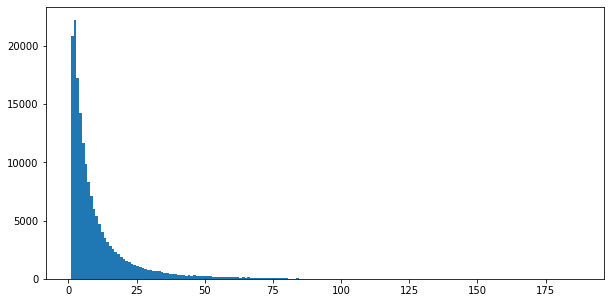

In [3]:
plt.figure(figsize=(10,5))
plt.hist(x=train['hindex'],bins=187);

**selection of sub-dataset with same distribution than the original**

**Tout le dataset (Préalablement enregistré en csv)**

In [4]:
# store_whole_dataset(train) # si tu n'as pas encore tout le dataset en local

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
174242


In [4]:
# l =[]
# for i in range (18):
#     l.append(pd.read_csv("../tmp/data_part"+str(i+1)+".csv"))

# data = pd.concat(l)
# data = small_class(data, 6)
# data.head()

,author,hindex,text,nb_paper,mean_coauthors_hindex,n_coauthors,modindx,hindex_lab
0,1964267543,4.0,contextual proximity detection or co presence ...,5,21.800000,5,0,__label__0
1,2153592714,13.0,motorola seamless mobility solution is one spe...,5,20.000000,1,4,__label__4
2,217158525,8.0,traditional software development approaches do...,5,2.000000,1,4,__label__4
3,2123103677,11.0,we describe the results of developing the gems...,3,11.833333,6,4,__label__4
4,2067710487,3.0,social software shows fascinating range of usa...,2,9.841160,0,0,__label__0


**Juste 10000 données**

In [3]:
data_path = "../tmp/data_10000.csv"
# data = preprocessing_for_fastText(10000,train)
# data.to_csv(data_path,index=None)
data = pd.read_csv(data_path)
data = small_class(data, 6)
data.head()

,author,hindex,text,nb_paper,mean_coauthors_hindex,n_coauthors,modindx,hindex_lab
0,2192797973,15.0,we present newly collected data set of gold st...,5,12.000000,6,0,__label__0
1,2568812976,4.0,problem to be solved to provide tv system for ...,5,16.500000,2,1,__label__1
2,2159374572,24.0,this paper presents novel engine coined topx f...,5,16.716981,53,0,__label__0
3,2745744053,22.0,this paper describes coherent optical orthogon...,5,16.000000,4,0,__label__0
4,2127692187,18.0,method for real time detection of denial of se...,4,15.666667,3,0,__label__0


In [4]:
data.describe()

,author,hindex,nb_paper,mean_coauthors_hindex,n_coauthors,modindx
count,9.796000e+03,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000
mean,1.993336e+09,9.841160,3.977338,15.514139,9.563699,1.943344
std,6.393600e+08,12.055575,1.323559,11.152517,39.555898,1.597585
min,1.139156e+07,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.019859e+09,3.000000,3.000000,8.000000,2.000000,1.000000
50%,2.133884e+09,6.000000,5.000000,12.500000,3.000000,1.000000
75%,2.286076e+09,12.000000,5.000000,20.000000,6.000000,4.000000
max,2.908001e+09,163.000000,5.000000,131.000000,930.000000,5.000000


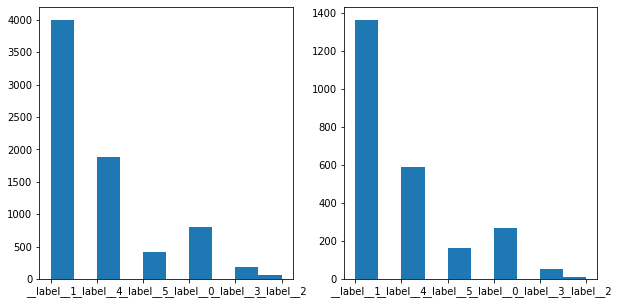

In [5]:
train1,test1 = train_test_split(data,random_state=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train1['hindex_lab'])
plt.subplot(1,2,2).hist(test1['hindex_lab']);

In [6]:
train_path = "../tmp/train1.txt"
test_path = "../tmp/test1.txt"

df_to_txt(train1,train_path)
df_to_txt(test1,test_path)

### Utilisation de Fast text

Les paramètre optimaux ont été optimisés pour 10000 données dans un autre jupyter avec un temps long. Le model 1 nest plus nécessaire!

In [7]:
model0 = fasttext.train_supervised(train_path,lr = 0.626905, dim = 12, epoch = 11, wordNgrams =3)

Read 4M words
Number of words:  68513
Number of labels: 6
Progress: 100.0% words/sec/thread: 2410425 lr:  0.000000 avg.loss:  0.914776 ETA:   0h 0m 0s


In [ ]:
# train_duration = 60 # in seconds
# model1 = fasttext.train_supervised(train_path, autotuneValidationFile=test_path, autotuneDuration=train_duration)

In [8]:
model0.test(test_path)

(2449, 0.5765618619844834, 0.5765618619844834)

In [ ]:
# model1.test(test_path)

In [ ]:
# comp = pd.DataFrame({'paramètre':['hidden layer','learning rate','epoch','loss'],'model0':[model0.dim,model0.lr,model0.epoch,model0.loss],'model1':[model1.dim,model1.lr,model1.epoch,model1.loss]})
# comp

In [ ]:
# comp =general_comp(model1,test1)
# comp.head()

**exploitation de model**

On est sur que le modèle applique softmax sur la représentation du mot. Nous ou choisit donc d'appliquer un autre régresseur

**Data for multiple regression model**

In [9]:
train_core_number = get_core_number(train1["author"])
test_core_number = get_core_number(test1["author"])

X_train,y_train = format_data(train1, model0, train_core_number)
X_test, y_test = format_data(test1, model0, test_core_number)

**Random forest**

In [18]:
print(X_train[:, :-1].shape)

(7500, 15)


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train[:, :-1],y_train)

RandomForestRegressor(random_state=1)

In [11]:
mod_preds = forest_model.predict(X_test[:, :-1])

In [12]:
mean_squared_error(y_test,mod_preds)

73.96608746427113

**XG_BOOST**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

model_xg = XGBRegressor()
parameters = {
    'learning_rate':[0.01,0.1,0.6],
    'max_depth':[3,5,10],
    'subsample':[0.5,0.7],
    'n_estimators':[300,500],
    'objective':['reg:linear']
}
model_tune = GridSearchCV(estimator=model_xg,param_grid = parameters,scoring = 'neg_mean_squared_error',cv =3, n_jobs=-1)

In [ ]:
model_tune.fit(X_train,y_train)
print(model_tune.best_params_)
print(model_tune.best_score_)

[01:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 0.5}
-45.013116800100214


**test linear regression**

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)

In [ ]:
reg_pred = reg.predict(X_test)

In [ ]:
mean_squared_error(y_test,reg_pred)

94.56054104116866

**test svm**

In [ ]:
from sklearn.svm import SVC

model_svm =SVC(kernel='sigmoid', C=2)

In [ ]:
model_svm.fit(X_train,y_train)

SVC(C=2, kernel='sigmoid')

In [ ]:
svm_pred = model_svm.predict(X_test)

In [ ]:
mean_squared_error(y_test,svm_pred)

155.67465894997932

**Test CNN**

In [ ]:
# mlp = MLP

# Soumission

In [ ]:
from submit import submit

submit()